<a href="https://colab.research.google.com/github/outsitting/Final/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from pprint import pprint
RANDOM_SEED = 76

In [232]:
pd.options.display.max_rows = 999

#### Загрузим данные

In [233]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [234]:
path = "/content/drive/MyDrive/Colab Notebooks/FinalProject/data.csv"
df = pd.read_csv(path)

In [235]:
df.head(5)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [236]:
df.columns

Index(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'fireplace', 'city', 'schools', 'sqft', 'zipcode', 'beds',
       'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target'],
      dtype='object')

В датасете 18 колонок

Целевая переменная 'target' - цена объекта недвижимости
* 'status' - статус объявления
* 'private pool' - наличие бассейна, вероятно дублируется столбцом 'PrivatePool'
* 'propertyType' - 'тип' объекта недвижимости
* 'street'- адрес
* 'baths' - количество ванных комнат
* 'homeFacts'- информация о доме. Этот столбец надо парсить
* 'fireplace' - наличие камина
* 'city' - город
* 'schools' - рейтинг и близость образовательных учреждений. Нужно парсить
* 'sqft' - площадь в квадратных футах
* 'zipcode' - почтовый индекс
* 'beds'- количество спальен (или количество кроватей) 
* 'state' - штат
* 'stories' - вероятно, количество владельцев или продаж этого дома
* 'mls-id' - идентификационный номер в системе MLS. Вероятно, дополняется столбцом 'MlsId'





In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

## 1. Data Preprocesing

Посмотрим сколько пропусков в данных

In [238]:
df.isna().sum()

status           39918
private pool    373004
propertyType     34733
street               2
baths           106338
homeFacts            0
fireplace       274070
city                34
schools              0
sqft             40577
zipcode              0
beds             91282
state                0
stories         150715
mls-id          352243
PrivatePool     336874
MlsId            66880
target            2481
dtype: int64

Семь столбцов (включая целевую переменную) содержат пропуски. В процессе предобработки попробуем извлечь максимум пользы и из неполных данных.

Визуализируем пропуски:

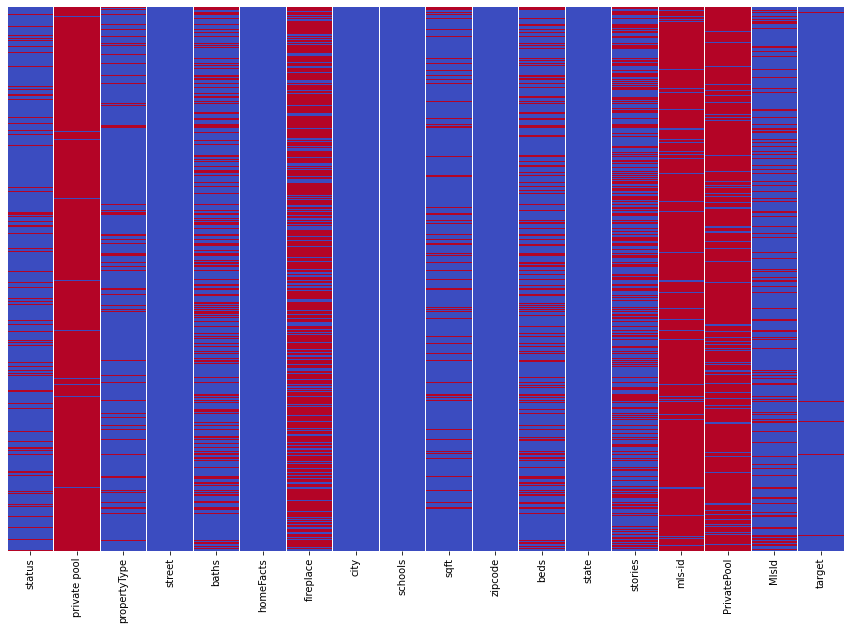

In [239]:
fig, ax = plt.subplots(figsize=(15,10))
sns_heatmap=sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap= 'coolwarm')

In [240]:
df.shape

(377185, 18)

In [241]:
# df = df.dropna(subset=['target'])
# df.shape

In [242]:
# df = df.drop_duplicates()
# df.shape

In [243]:
# df.reset_index(drop=True, inplace=True)

 ### 1.0 Столбцы 'mls-id' и 'MlsId'

Начнем с удаления дубликатов и столбцов в названиях которых присутвует "id".
В них больше всего пропусков, соответственно, доболнение датасета данными из другой базы данных, например американской базы риелторов по этим id, представляется нецелесообразным, так как датасет будет дополнен неравномерно.

In [245]:
#df['MlsId'].fillna(df['mls-id'], inplace=True)

In [246]:
#df['MlsId'].value_counts() >= 2

In [247]:
df[df['MlsId'] == '1412350']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
34904,NaN,NaN,Multi Family,354 E Terra Alta Dr,3.0,"{'atAGlanceFacts': [{'factValue': '1968', 'fac...",NaN,San Antonio,"[{'rating': ['6/10', '7/10', '7/10'], 'data': ...","3,345",78209,5,TX,NaN,NaN,NaN,1412350,"$489,000"
80958,Active,NaN,NaN,354 E Terra Alta Dr,"2,000","{'atAGlanceFacts': [{'factValue': '1968', 'fac...",NaN,San Antonio,"[{'rating': ['6', '7', '6'], 'data': {'Distanc...","3,345",78209,Baths,TX,NaN,NaN,NaN,1412350,"489,000"
175906,Active,NaN,Residential (<1 Acre),11936 Lakeside Pl NE,"2,750","{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Seattle,"[{'rating': ['5', '8', '6', '7', '6', '8'], 'd...",NaN,98125,Baths,WA,NaN,NaN,NaN,1412350,"199,975"
291507,for sale,NaN,multi-family,354 E Terra Alta Dr,3 Baths,"{'atAGlanceFacts': [{'factValue': '1968', 'fac...",NaN,San Antonio,"[{'rating': ['7/10', '7/10', '6/10'], 'data': ...","3,345 sqft",78209,5 Beds,TX,NaN,NaN,NaN,1412350,"$489,000"
303749,for sale,NaN,lot/land,11936 Lakeside Pl NE,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Seattle,"[{'rating': ['5/10', '6/10', '6/10'], 'data': ...",NaN,98125,NaN,WA,NaN,NaN,NaN,1412350,"$199,975"
308314,Active,NaN,Land,11936 Lakeside Pl NE,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Seattle,"[{'rating': ['5', '6', '6', '6', '7', 'NR', 'N...",0,98125,NaN,WA,NaN,NaN,NaN,1412350,"$199,975"


По самому частому 'MlsId' 6 записей по 3 в SAN ANTONIO и SEATTLE.
Данные дублируют друг друга. Желательно удалить строки дубликатов.

 ### 1.1 Столбец "status"

In [248]:
df.status = df.status.str.upper()

In [249]:
df.status.nunique()

152

Имеем 152 различных значения. 

Посмотрим на них:

In [250]:
df.status.value_counts()[:50]

FOR SALE                             199571
ACTIVE                               105207
FORECLOSURE                            6769
NEW CONSTRUCTION                       5475
PENDING                                4807
PRE-FORECLOSURE                        2119
PRE-FORECLOSURE / AUCTION              1560
P                                      1488
UNDER CONTRACT SHOW                    1183
 / AUCTION                              936
UNDER CONTRACT   SHOWING                793
ACTIVE UNDER CONTRACT                   718
UNDER CONTRACT                          692
NEW                                     690
CONTINGENT                              581
PRICE CHANGE                            563
AUCTION                                 536
FORECLOSED                              459
A ACTIVE                                443
FOR RENT                                398
RECENTLY SOLD                           287
UNDER CONTRACT BACKUPS                  252
CONTINGENT FINANCE AND INSPECTIO

In [251]:
df.status.isnull().value_counts()

False    337267
True      39918
Name: status, dtype: int64

* имеем больше 250.000 записей о продаже готовой недвижимости 'active', 'for sale'
* 'NaN' значений около 40.000
* также много записей о строящемся жилье 'pending'
* о выкупе у должников 'foreclosure'
* отдельно указываются новостройки 

Не очень понятна принципиальная разница между категориями 'ACTIVE' и 'FOR SALE'. Они по сути отражают одно и то же сотояние объекта недвижимоти - готовность объекта к продаже(активное объявление). Также непонятно какими данными заполнять пустые значения. Раз они присутствуют в датасете - они должны быть активными и готовыми к продаже, как и абсолютное большинство других объявлений. Но если все три вышеуказанных категории заменить одним значением, например, 'ACTIVE', то данные в этом признаке будут сильно несбалансированные. Да и пропуски могут нести каку-то смысловую нагрузку. Поэтому, пусть останутся три разных значения: 'ACTIVE', 'FOR SALE' и "NO_DATA" соответственно.

Из этого столбца нужно будет сделать категориальный признак


In [252]:
def parseSTAT(s, ind):
    s = str(s)
    if 'AUCTION' in s: return 'AUCTION'
    if 'COMIN' in s or 'DILIGE' in s: return 'COMING'
    if 'RENT' in s: return 'RENT'
    if 'LEASE' in s: return 'RENT'
    if 'PURCH' in s: return 'RENT'
    if 'PEND' in s: return 'PENDING'
    if 'FOREC' in s: return 'FORECLOSURE'
    if 'NEW' in s: return 'NEW'
    if 'CONTRACT' in s: return 'CONTRACT'
    if 'CONTINGE' in s: return 'CONTINGENT'
    if 'SOLD' in s or 'CLOSED' in s or 'ACCEPT' in s: return 'SOLD'
    if 'ACTIV' in s: return 'ACTIVE'
    if 'FOR SALE' in s: return 'FOR SALE'
    if 'BACKUP' in s: return 'CONTRACT'
    if 'BACK' in s or 'EXTEND' in s: return 'ACTIVE'
    if 'CONTINUE' in s: return 'ACTIVE'
    if s == 'C' or  s == 'CT': return 'CONTRACT'
    if s == 'P': return 'PENDING'
    if s == 'PS' or s == 'PF' or s == 'PI': return 'PENDING'
    if s == 'nan' : return  "NO_DATA" # 'ACTIVE'
    else: return s 


In [253]:
def list_impl_STAT(df):
  res = pd.DataFrame([
    parseSTAT(string, ind)
    for (string, ind) in zip(df['status'], df.index)
  ])
  
  return res

In [254]:
dfSTAT = list_impl_STAT(df)

In [255]:
dfSTAT.value_counts()

FOR SALE        199571
ACTIVE          105909
NO_DATA          39918
FORECLOSURE       9349
PENDING           6891
NEW               6165
CONTRACT          3848
AUCTION           3070
CONTINGENT        1027
PRICE CHANGE       563
RENT               424
SOLD               313
COMING             137
dtype: int64

In [256]:
#df = df.join(dfSTAT)
df.status = dfSTAT

In [257]:
df[df.status == 'RENT']['target'][:8]

547      $5,500/mo
609     $10,500/mo
2075     $6,390/mo
3025     $1,200/mo
3645     $3,600/mo
4613     $5,500/mo
5515     $1,200/mo
5873        $1,250
Name: target, dtype: object

Получили 11 категорий "статуса" недвижимости. Сделаем этот признак категориальным.

Необходимо будет удалить 424 записи со статусом 'RENT' - это объявления о сдаче недвижимости в аренду и цена на нее горадо ниже, чем на продажу. Также в стоимости присутствует приписка о помесячной оплате '/mo'. Эти записи будут вносить шум в данные.

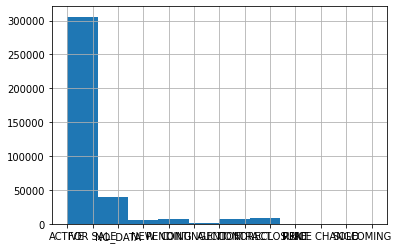

In [258]:
df.status.hist()

 ### 1.2 Столбцы "private pool" и "PrivatePool"


In [259]:
df['private pool'].unique()

array([nan, 'Yes'], dtype=object)

In [260]:
df['PrivatePool'].unique()

array([nan, 'yes', 'Yes'], dtype=object)

In [261]:
df['PrivatePool'][df['private pool'] == 'Yes']

205       NaN
321       NaN
355       NaN
404       NaN
425       NaN
         ... 
376627    NaN
376686    NaN
376694    NaN
376853    NaN
377112    NaN
Name: PrivatePool, Length: 4181, dtype: object

In [262]:
df['PrivatePool'][df['private pool'] == 'Yes']

205       NaN
321       NaN
355       NaN
404       NaN
425       NaN
         ... 
376627    NaN
376686    NaN
376694    NaN
376853    NaN
377112    NaN
Name: PrivatePool, Length: 4181, dtype: object

Данные из столбцов не пересекаются.

Заполним NaN нулями, заменим 'Yes' и 'yes' на единицы и объединим эти два столбца

In [263]:
df['PrivatePool'].fillna(df['private pool'], inplace=True)
df['PrivatePool'].fillna(value=0, inplace=True)
df['PrivatePool'][df['PrivatePool'] == 'yes'] = 1
df['PrivatePool'][df['PrivatePool'] == 'Yes'] = 1

In [264]:
df.drop(['private pool'], axis=1, inplace=True)

 Вместо двух столбцов получили один объединенный столбец 'PrivatePool' со значениями 1 и 0 (есть и нету бассейна) соответственно. 

### 1.3 Столбец "propertyType"



In [265]:
df.propertyType = df.propertyType.str.upper()
df.propertyType.nunique()

1272

Имеем 1272 описаний типа недвижимости. Надо разбить на разумное число категорий.

In [266]:
df.propertyType.value_counts()[:50]

SINGLE-FAMILY HOME                      92206
SINGLE FAMILY                           62869
CONDO                                   42529
SINGLE FAMILY HOME                      31728
LOT/LAND                                20552
TOWNHOUSE                               18400
LAND                                    10934
MULTI-FAMILY                             7921
CONDO/TOWNHOME/ROW HOME/CO-OP            7701
TRADITIONAL                              5913
COOP                                     3266
MULTI FAMILY                             2794
HIGH RISE                                1823
RANCH                                    1781
MOBILE/MANUFACTURED                      1618
DETACHED, ONE STORY                      1614
SINGLE DETACHED, TRADITIONAL             1581
CONTEMPORARY                             1557
MULTI-FAMILY HOME                        1501
1 STORY                                  1235
COLONIAL                                 1205
MOBILE / MANUFACTURED             

In [267]:
def parsePT(s, ind):
    s = str(s)
    if 'SINGLE' in s or 'TRADITIONAL' in s: return 'SINGLE'
    if 'CONDO' in s or 'FLAT' in s: return 'FLAT'
    if 'TOWNH' in s: return 'TOWNHOUSE'
    if 'COOP' in s or 'CO-OP' in s: return 'COOP'
    if 'LAND' in s: return 'LAND'
    if 'MULTI' in s: return 'MULTI'
    if 'CONTEMPO' in s: return 'CONTEMPORARY'
    if 'MOBI' in s or 'CARRI' in s: return 'MOBILE'
    if 'TWO STOR' in s or '2 STOR' in s: return 'TWO-STORY'
    if 'ONE STOR' in s or '1 STOR' in s: return 'ONE-STORY'
    if 'STOR' in s in s: return 'MULTY-STORY'
    if 'DETA' in s or 'DETA' in s: return 'DETACHED'
    # if 'MID' in s or '5-9' in s  or '4' in s or '3' in s: return 'MID-RISE'
    # if 'LOW' in s: return 'LOW-RISE'
    # if 'HIGH' in s or 'UNIT' in s: return 'HIGH-RISE'
    if 'RISE' in s or 'UNIT' in s or 'HIGH' in s: return 'FLAT'
    if 'PENT' in s: return 'PENTHOUSE'
    if 'RAN' in s: return 'RANCH'
    if 'GARD' in s: return 'GARDEN HOME'
    if 'CUST' in s or 'MANUF' in s or 'CRAFT' in s: return 'CUSTOM'
    if 'ATTA' in s or 'PLEX' in s: return 'ATTACHED'
    if 'FARM' in s: return 'FARM'
    if 'LEVEL' in s: return 'SPLIT-LEVEL'
    if 'OTHER' in s: return 'OTHER'
    if 'COLO' in s: return 'COLONIAL'
    if 'WARE' in s or 'COM' in s: return 'COMMERCICAL'
    if 'COTT' in s or 'RESID' in s or 'COURT' in s: return 'COTTAGE'
    if 'BOAT' in s: return 'BOATHOUSE'

    if s == 'nan' or s == '': 
        return 'SINGLE'

    else:
         return 'OTHER'

In [268]:
def list_impl_PT(df):
  res = pd.DataFrame([
    parsePT(string, ind)
    for (string, ind) in zip(df['propertyType'], df.index)
  ])
  return res

In [269]:
dfPT = list_impl_PT(df)

In [270]:
dfPT.value_counts()

SINGLE          233057
FLAT             53018
LAND             31494
TOWNHOUSE        18575
MULTI            12499
OTHER             4427
ONE-STORY         4009
COOP              3840
MOBILE            3521
RANCH             3475
CONTEMPORARY      3383
TWO-STORY         2505
COLONIAL          1257
CUSTOM             477
GARDEN HOME        358
SPLIT-LEVEL        345
MULTY-STORY        230
COTTAGE            199
ATTACHED           179
DETACHED           157
PENTHOUSE           79
FARM                78
COMMERCICAL         19
BOATHOUSE            4
dtype: int64

Последние три значения 'FARM' - ферма, 'COMMERCICAL' -коммерческая недвижимость и 'BOATHOUSE' - эллинг(или причал) относятся к коммерческой недвижимости. Они явно будут вносить шум в данные. Эти записи необходимо будет удалить.

In [271]:
dfPT.nunique()

0    24
dtype: int64

In [272]:
df.propertyType = dfPT

Получили 24 категории недвижимости. Сделаем из этого столбца категориальный признак.

### 1.4 Столбец "street"

In [273]:
df.street = df.street.str.upper()

In [274]:
df.street.nunique()

336266

In [275]:
df.street.value_counts().head(300)

ADDRESS NOT DISCLOSED                 672
UNDISCLOSED ADDRESS                   517
(UNDISCLOSED ADDRESS)                 391
ADDRESS NOT AVAILABLE                 175
UNKNOWN ADDRESS                        72
2103 E STATE HWY 21                    57
11305 GULF FWY                         54
17030 YOUNGBLOOD RD.                   38
NE 58TH CIR                            34
9470 LANCASTER RD. SW                  32
1 PALMER DR                            27
8426 TERRACE VALLEY CIRCLE             25
9845 BASIL WESTERN RD NW               25
6320 SW 89TH COURT ROAD                24
8447 SW 99TH STREET RD                 22
5221 S. ZAPATA HWY                     20
WHITETAIL TRAIL                        19
STONE BLUFF DRIVE                      18
2005 WEST HAPPY VALLEY ROAD            17
1365 NEIHART WAY                       17
3435 HEATHER GARDEN TRAIL              17
BONCHER BLVD                           17
3423 HEATHER GARDEN TRAIL              17
24423 FERDOSSA DRIVE              

Имеем 336 тысяч уникальных адресов. 
Была идея извлечь из адресов геолокацию, или, папример, рассчитывать расстояния до центра населенного пункта, руководствуясь идеей "чем ближе к центу - тем дороже".
Однако, принял решение не добавлять эти сомнительные признаки.

В этой колонке данные неплохо стркуктурированы. Почти в каждом адресе есть аббревиатуры типа улицы, например 'BLVD' -бульвар, 'ROAD' - дорога и т.п. 
Не заню американскую специфику и пренципиальную разницу в обозначениях улиц, но, предполагаю, что тут может скрываться некоторая смысловая нагрузка.
Попробуем из столбца 'street' сделать категориальный признак с типа улицы.   

In [276]:
def parseSTREET(s, ind):
    s = str(s)
    
    if 'ADDRESS' in s: return 'NO_ADDRESS'
    elif 'BLVD' in s or 'BOULEVARD' in s: return 'BOULEVARD'
    elif 'WAY' in s: return 'HWAY'
    elif 'CIR' in s: return 'CIRCLE'
    elif 'CT' in s or 'COURT' in s: return 'COURT'
    elif 'DR' in s or 'DRIVE' in s: return 'DRIVE'
    elif 'RD' in s or 'ROAD' in s: return 'ROAD'
    elif 'AVE' in s: return 'AVENUE'
    elif 'ST' in s or 'STREET' in s: return 'STREET'
    elif 'PL' in s: return 'PLACE'
    elif 'LANE' in s: return 'LANE'
    elif 'TR' in s or 'TRL' in s or 'TRAIL' in s: return 'TRAIL'
    elif 'PARK' in s: return 'PARK'
    else: return 'OTHER'

In [277]:
def list_impl_STREET(df):
  res = pd.DataFrame([
    parseSTREET(string, ind)
    for (string, ind) in zip(df['street'], df.index)
  ])
  return res

In [278]:
dfSTREET = list_impl_STREET(df)

In [279]:
dfSTREET.value_counts()

STREET        86131
DRIVE         65654
AVENUE        60712
OTHER         43818
ROAD          43261
COURT         20015
PLACE         15301
BOULEVARD     13639
HWAY          12557
CIRCLE         8831
TRAIL          4345
NO_ADDRESS     1835
PARK            747
LANE            339
dtype: int64

In [280]:
df.street = dfSTREET

In [281]:
#df['adress'] = [str(x) + ' ' + str(y) + ' ' + str(z) for x, y, z in zip(df['street'], df['city'], df['state'])

### 1.5 Столбец "baths"


In [282]:
df.baths.value_counts().head(15)

2 Baths         52466
3 Baths         35506
2               20452
2.0             16576
4 Baths         14764
3.0             10869
3               10113
Bathrooms: 2     9538
2.5              8113
Bathrooms: 3     6613
1                6583
1.0              5930
5 Baths          5370
4.0              4593
2.5 Baths        4486
Name: baths, dtype: int64

106338 домов без ванны... Гигиена? Не, не слышали.

In [283]:
df.baths = df.baths.str.upper()

In [284]:
def parseBATHS(s, ind):
    s = str(s)
    if s == '0': return 0.0
    if s == '': return 1.0
    if s == 'nan': return 1.0
    if 'SQ. FT.' in s: return 1.0
    if '-' in s or '—' in s or '~' in s: return 0.0
    if 'SEMIMOD' in s: return 1.0
    #if '/' in s: print(s)

    s = s.replace(',', '.')
    f = re.findall(r'\d*\.\d+|\d+', s)
    try:
        n = float(f[0])
        if n >= 200:
            n = n / 1000.
        return n
    except:
        print(s)
  
    return 1.0

In [285]:
def list_impl_BATHS(df):
  res = pd.DataFrame([
    parseBATHS(string, ind)
    for (string, ind) in zip(df['baths'], df.index)
  ])
  return res

In [286]:
dfBATHS = list_impl_BATHS(df)

In [287]:
dfBATHS.value_counts()[:10]

1.0    124325
2.0    103518
3.0     66682
4.0     26333
2.5     13786
5.0      9453
3.5      6156
0.0      5217
1.5      4363
6.0      4303
dtype: int64

### 1.6 Столбец "homeFacts"

In [288]:
df.homeFacts[1]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '5828 sqft', 'factLabel': 'lotsize'}, {'factValue': '$159/sqft', 'factLabel': 'Price/sqft'}]}"

In [289]:
def clen(string):
  string = string.replace("''", '0')
  string = string.replace("'", "")
  string = string.replace("None", '0')
  string = string.replace("No Data", '0')
  string = string.replace("No Info", '0')
  string = string.replace("/sqft", '')
  string = string.replace("$", '')
  return string

In [290]:
def parseHF(s, ind):
  res = []
  s = s.split("{'atAGlanceFacts': [{'factValue': ")[1]
  s = s.split(", 'factLabel': 'Year built'}, {'factValue': ")
  s[0] = clen(s[0])
  # year = s[0]
  res.append(s[0])
  s = s[1].split(", 'factLabel': 'Remodeled year'}, {'factValue': ")
  s[0] = clen(s[0])
  # remo = s[0]
  res.append(s[0])
  s = s[1].split(", 'factLabel': 'Heating'}, {'factValue': ")
  # heat = s[0]
  res.append(s[0])
  s = s[1].split(", 'factLabel': 'Cooling'}, {'factValue': ")
  # cool = s[0]
  res.append(s[0])
  s = s[1].split(", 'factLabel': 'Parking'}, {'factValue': ")
  s[0] = clen(s[0])
  # park = s[0]
  res.append(s[0])
  s = s[1].split(", 'factLabel': 'lotsize'}, {'factValue': ")
  # size = s[0]
  res.append(s[0])
  s = s[1].split(", 'factLabel': 'Price/sqft'}]}")
  s[0] = clen(s[0])
  # price = s[0]
  res.append(s[0])
  return int(res[0]), int(res[1]), res[2], res[3], res[4], res[5], res[6]

In [291]:
def list_impl(df):
  res = pd.DataFrame([
    parseHF(string, ind)
    for (string, ind) in zip(df['homeFacts'], df.index)
  ])
  
  return res

In [292]:
dfHF = list_impl(df)

In [293]:
dfHF.columns = ['Built_Year', 'Remodeled_Year', 'Heating', 'Cooling', 'Parking', 'Size', 'Price_sqft']

In [294]:
#dfHF['Price_sqft'].value_counts()[:100]

In [295]:
#df = df.join(dfHF)

In [296]:
dfHF['Built_Year'].value_counts()

0               63596
2019            32171
2006             8008
2005             7503
2007             7152
2018             6857
2004             5506
2017             5184
2016             5099
2008             5009
2003             4565
1950             4554
1920             4330
2002             4266
2001             4207
1925             4193
2015             3871
1955             3686
1960             3667
2000             3618
1974             3453
1973             3434
1999             3397
1979             3351
1972             3304
1980             3279
1981             3216
1940             3149
1984             3124
1998             3117
2014             3100
1970             3078
1930             3051
1978             3021
1985             3011
1983             2980
1997             2873
1989             2815
1986             2805
1987             2709
1956             2696
1965             2693
1900             2692
1968             2690
1971             2687
1959      

In [297]:
#dfHF[dfHF['Built_Year'] == '0']['Built_Year'] = dfHF[dfHF['Built_Year'] == '0']['Remodeled_Year']
#dfHF.loc[dfHF['Built_Year'] == 0]['Built_Year'] = dfHF.loc[dfHF['Built_Year'] == 0]['Remodeled_Year']

In [298]:
dfHF['Built_Year'].replace(559990649990, 0, inplace=True)
dfHF['Built_Year'].replace(1, 0, inplace=True)

In [299]:
len(dfHF[dfHF['Built_Year'] == '0']['Remodeled_Year'] != '0')

0

In [300]:
dfHF

,Built_Year,Remodeled_Year,Heating,Cooling,Parking,Size,Price_sqft
0,2019,0,"'Central A/C, Heat Pump'",'',0,None,144
1,2019,0,'','',0,'5828 sqft',159
2,1961,1967,'Forced Air','Central',Attached Garage,"'8,626 sqft'",965
3,2006,2006,'Forced Air','Central',Detached Garage,"'8,220 sqft'",371
4,0,0,'','',0,"'10,019 sqft'",0
...,...,...,...,...,...,...,...
377180,1990,1990,'Other','Central',2 spaces,"'8,500 sqft'",311
377181,1924,0,'Radiant','',0,'',337
377182,1950,1950,'Other','',2,"'1,600 sqft'",458
377183,0,0,None,None,0,None,0


In [301]:

dfHF['Built_Year'] = dfHF['Built_Year'].astype(float)

In [302]:
#len(dfHF[dfHF['Built_Year'] == '0'])

In [303]:
dfHF['Remodeled_Year'].value_counts()[:20]

0       226380
2006      5538
2005      4817
2007      4387
2008      3796
2004      3371
1980      3339
1970      3153
2000      3068
2003      2828
1985      2819
2002      2716
1975      2694
1990      2657
1965      2619
1983      2454
2001      2442
1995      2375
1988      2351
1962      2236
Name: Remodeled_Year, dtype: int64

Две трети значений о модернизации недвижимости имеют значение 0. Видимо, модернизация не проводилась. Можно сделать этот столбец бинарным. Все значения отличные от 0 заменить на 1.

In [304]:
dfHF.Remodeled_Year[dfHF['Remodeled_Year'] != 0] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [305]:
dfHF.describe()

,Built_Year,Remodeled_Year
count,377185.000000,377185.000000
mean,1645.507329,0.399817
std,741.696069,0.489861
min,0.000000,0.000000
25%,1926.000000,0.000000
50%,1974.000000,0.000000
75%,2005.000000,1.000000
max,2025.000000,1.000000


In [306]:
dfHF.Heating = dfHF.Heating.str.upper()

In [307]:
dfHF.Heating.value_counts()[:30]

'FORCED AIR'                     134313
''                               105799
'OTHER'                           29623
'ELECTRIC'                        10217
'GAS'                              9299
'HEAT PUMP'                        8851
'NO DATA'                          8611
'CENTRAL AIR'                      7814
'CENTRAL ELECTRIC'                 7112
'CENTRAL'                          6247
'CENTRAL, ELECTRIC'                4253
'BASEBOARD'                        3815
NONE                               3533
'WALL'                             3301
'ELECTRIC HEAT'                    3064
'HEATING SYSTEM'                   2709
'FORCED AIR, HEAT PUMP'            1767
'RADIANT'                          1485
'CENTRAL AIR, CEILING FAN(S)'      1432
'NATURAL GAS HEAT'                 1383
'CENTRAL FURNACE'                  1036
'FORCED AIR, GAS'                   962
'CENTRAL ELECTRIC, ZONED'           873
'FORCED AIR HEATING'                810
', GAS HOT AIR/FURNACE'             776


In [308]:
def parseHEAT(s, ind):
    s = str(s)
    if len(s) == 0 or s == '' or s =="''" or s == ' ' or 'NO DATA' in s: return 'NO_DATA'
    if 'AIR' in s or 'HEAT PUMP' in s: return 'AIR'
    if 'GAS' in s or 'PROPANE' in s: return 'GAS'
    if 'ELECTRIC' in s: return 'ELECTRIC'
    if 'NONE' in s or 'NO' in s: return 'NONE'
    if 'CENTRAL' in s: return 'CENTRAL'
    else: return 'OTHER'

In [309]:
def list_impl_HEAT(dfHF):
  res = pd.DataFrame([
    parseHEAT(string, ind)
    for (string, ind) in zip(dfHF['Heating'], dfHF.index)
  ])
  return res

In [310]:
dfHF['Heating'] = list_impl_HEAT(dfHF)
dfHF['Heating'].value_counts()[:30]

AIR         164584
NO_DATA     114410
OTHER        44444
ELECTRIC     26789
GAS          14804
CENTRAL       8446
NONE          3708
Name: Heating, dtype: int64

In [311]:
dfHF.Cooling = dfHF.Cooling.str.upper()

In [312]:
dfHF.Cooling.value_counts()[:30]

'CENTRAL'                                            158754
''                                                   120434
'CENTRAL AIR'                                         14384
'NO DATA'                                             10616
'HAS COOLING'                                          9730
'NONE'                                                 7390
'CENTRAL ELECTRIC'                                     6154
'WALL'                                                 4018
'CENTRAL GAS'                                          3573
NONE                                                   3533
'CENTRAL HEATING'                                      2807
'COOLING SYSTEM'                                       2700
'CENTRAL A/C'                                          2051
'OTHER'                                                1840
'CENTRAL A/C (ELECTRIC), CENTRAL HEAT (GAS)'           1646
'CENTRAL A/C (ELECTRIC), CENTRAL HEAT (ELECTRIC)'      1429
'REFRIGERATION'                         

In [313]:
def parseCOOL(s, ind):
    s = str(s)
    if len(s) == 0 or s == '' or s =="''" or s == ' ' or 'NO DATA' in s: return 'NO_DATA'
    #if 'EVAPORATIVE' in s: return 'EVAPORATIVE'
    if 'CENTRAL' in s: return 'CENTRAL'
    if 'NONE' in s or 'NO' in s: return 'NONE'
    else: return 'OTHER'

In [314]:
def list_impl_COOL(dfHF):
  res = pd.DataFrame([
    parseCOOL(string, ind)
    for (string, ind) in zip(dfHF['Cooling'], dfHF.index)
  ])
  return res

In [315]:
dfHFcool = list_impl_COOL(dfHF)
dfHFcool.value_counts()[:30]

CENTRAL    204545
NO_DATA    131050
OTHER       30422
NONE        11168
dtype: int64

In [316]:
dfHF.Parking = dfHF.Parking.str.upper()

In [317]:
dfHF.Parking.value_counts()[:30]

0                                   192234
ATTACHED GARAGE                      70752
2 SPACES                             28063
1 SPACE                              14252
DETACHED GARAGE                      13201
CARPORT                               7743
OFF STREET                            5279
3 SPACES                              4724
CARPORT, ATTACHED GARAGE              3025
1                                     2936
4 SPACES                              2917
2                                     2756
ON STREET                             1707
ATTACHED GARAGE, DETACHED GARAGE      1354
ATTACHED GARAGE, CARPORT               993
PARKING DESC                           900
6 SPACES                               755
DETACHED GARAGE, ATTACHED GARAGE       726
DRIVEWAY                               693
5 SPACES                               655
4                                      603
OFF STREET PARKING                     573
OFF STREET, ATTACHED GARAGE            538
PARKING TYP

In [318]:
def parsePARKING(s, ind):
    s = str(s)
    #if len(s) == 0 or s == '' or s =="''" or s == ' ' or 'NO DATA' in s: return 'NO_DATA'
    if '1' in s or "ONE" in s or 'SING' in s: return 'ONE'
    elif '2' in s or "TWO" in s or "DOUB" in s: return 'TWO'
    elif '3' in s: return 'THREE'
    elif 'ATTACHED' in s: return 'ATTACHED'
    elif 'DETACHED' in s: return 'DETACHED'
    elif 'OFF' in s: return 'OFF_STREET'
    elif 'ON' in s: return 'ON_STREET'
    elif 'CAR' in s: return 'CARPORT'
    elif '4' in s or '5' in s or '6' in s or '7' in s or '8' in s or '9' in s: return 'FOUR_OR_MORE'
    elif 'NONE' in s or 'NO' in s or s == '0': return 'NONE'
    else: return 'OTHER'

In [319]:
def list_impl_PARKING(dfHF):
  res = pd.DataFrame([
    parsePARKING(string, ind)
    for (string, ind) in zip(dfHF['Parking'], dfHF.index)
  ])
  return res

In [320]:
dfHFparking = list_impl_PARKING(dfHF)
dfHFparking.value_counts()[:30]

NONE            192283
ATTACHED         80931
TWO              33563
ONE              18342
DETACHED         14739
CARPORT           8234
OTHER             7530
OFF_STREET        7174
FOUR_OR_MORE      6215
THREE             5608
ON_STREET         2566
dtype: int64

In [321]:
dfHF.Size = dfHF.Size.str.upper()

In [322]:
dfHF.Size.value_counts()[:30]

''               33067
NONE             28388
'—'              25251
'NO DATA'         5330
'-- SQFT LOT'     3819
'0.26 ACRES'      3140
'0.25 ACRES'      2723
'0.28 ACRES'      2617
'0.27 ACRES'      2474
'0.29 ACRES'      2351
'0.34 ACRES'      1953
'0.31 ACRES'      1720
'0.32 ACRES'      1582
'6,098 SQFT'      1525
'0.3 ACRES'       1439
'0.33 ACRES'      1413
'0.35 ACRES'      1357
'7,405 SQFT'      1357
'1 ACRE'          1349
'6,534 SQFT'      1292
'0.46 ACRES'      1287
'4,356 SQFT'      1270
'10,000 SQFT'     1260
'0.36 ACRES'      1224
'5,227 SQFT'      1175
'0.37 ACRES'      1172
'5,000 SQFT'      1117
'8,712 SQFT'      1030
'0.38 ACRES'       994
'3,920 SQFT'       993
Name: Size, dtype: int64

Столбец содержит данные о пощади. Возможно, площадь участка.

Около 96000 значений типа NONE,  ' ',  '—',  'NO DATA', '-- SQFT LOT'

Если пытаться сохранить информацию, то надо заменить данные 0 или большими значениями

In [323]:
def parseSIZE(s, ind):
    s = str(s)
    if len(s) == 0 or s == ' ':  return 0.0
    elif 'nan' in s: return 0.0
    elif s == '' or 'NO' in s or '—' in s or '-' in s: return 0.0
 
    elif ' SQ' in s: 
        s = s.replace(',', '')
        s = s.replace('.', '')
        s = s.replace('"', '')
        s = s.replace("'", '')
        s = s.split(' ')
        try:
            return float(s[0])
        except:
            print('EX_SQ', s)
            return 0.0

    elif ' AC' in s: 
        s = s.replace(',', '')
        s = s.replace('.', '')
        s = s.replace('"', '')
        s = s.replace("'", '')
        s = s.split(' ')
        try:
            return float(s[0])*43560
        except:
            print ('EX_AC', s)
            return 0.0
    
    else: 
        print ('EX', s)
        return s
 

In [324]:
def list_impl_SIZE(dfHF):
  res = pd.DataFrame([
    parseSIZE(string, ind)
    for (string, ind) in zip(dfHF['Size'], dfHF.index)
  ])
  return res

In [325]:
dfHFsize = list_impl_SIZE(dfHF)
dfHFsize.value_counts()[:30]

Выходные данные были обрезаны до нескольких последних строк (5000).
EX ''
EX '6969'
EX '143748'
EX '10061'
EX ''
EX ''
EX '7950'
EX '9999'
EX '28053'
EX ''
EX ''
EX ''
EX ''
EX ''
EX ''
EX '19200'
EX ''
EX '6316'
EX '0.29'
EX '8398'
EX ''
EX '2178'
EX ''
EX ''
EX '10149'
EX ''
EX ''
EX ''
EX ''
EX '7710'
EX '10000'
EX '8276'
EX ''
EX '15682'
EX '17860'
EX ''
EX '62726'
EX '9453'
EX '7617'
EX ''
EX '20909'
EX ''
EX ''
EX '9999'
EX '6500'
EX '2500'
EX ''
EX ''
EX '13068'
EX ''
EX ''
EX '10454'
EX ''
EX ''
EX '13939'
EX ''
EX '7128'
EX '43560'
EX ''
EX '9865'
EX ''
EX '6000'
EX '10000'
EX '6534'
EX '9680'
EX ''
EX '9868'
EX ''
EX '7634'
EX '7820'
EX '14810'
EX '7938'
EX '19602'
EX '12000'
EX '0.28'
EX '2178'
EX ''
EX '5545'
EX ''
EX '103673'
EX ''
EX '12588'
EX '10019'
EX '208217'
EX '12632'
EX ''
EX '5500'
EX ''
EX '45825'
EX ''
EX ''
EX '10254'
EX '8276'
EX '6822'
EX '7935'
EX '13715'
EX ''
EX ''
EX ''
EX ''
EX ''
EX '435600'
EX ''
EX ''
EX ''
EX ''
EX ''
EX '4323'
EX ''
EX '16117'
EX '

0.0          62790
''           33067
1132560.0     3441
1089000.0     3086
1219680.0     2870
1176120.0     2728
1263240.0     2580
6098.0        2324
7405.0        2173
1481040.0     2125
5000.0        2004
6534.0        1888
1350360.0     1886
10000.0       1874
4356.0        1763
5227.0        1737
1393920.0     1711
130680.0      1664
8712.0        1590
1437480.0     1565
8276.0        1514
43560.0       1498
1524600.0     1495
2003760.0     1377
1568160.0     1329
3920.0        1323
10018.0       1304
4791.0        1279
1611720.0     1277
9583.0        1234
dtype: int64

Данные гразные. Площадь есть в акрах, есть в квадратных футах, а есть без указания единиц измерения. Такой столбец очень, проблематично чистить. Можно попробовать по пороговому значению, но данны могут оказаться недостоверными. 

Пока не будем использовать этот столбец. 

In [326]:
dfHF.Price_sqft = dfHF.Price_sqft.str.upper()

In [327]:
dfHF.Price_sqft.value_counts()[:30]

0      66098
122     1444
121     1438
123     1437
127     1430
128     1429
125     1426
118     1426
132     1415
130     1408
115     1406
117     1396
116     1383
133     1382
120     1378
119     1370
141     1370
135     1368
124     1368
139     1354
131     1349
140     1341
136     1338
138     1335
111     1333
129     1327
114     1323
126     1321
134     1313
143     1313
Name: Price_sqft, dtype: int64

В этом столбце представлена площпдь за квадратный метр. 
66000 нулевых значений. Можно попробовать заменить их, например, медианными значениями по городу.

Непонятно, нассколько корректно использовать этот столбец. Он будет сильно коррелировать с целевой переменной, наряду с площадью недвижимости. Нужна конскльтация ментора.

In [328]:
#df = df.join(dfHF)

### 1.6 Столбец "fireplace"

In [329]:
df.fireplace.value_counts()[:30]

yes                          50356
Yes                          20856
1                            14544
2                             2432
Not Applicable                1993
Fireplace                      847
3                              564
Living Room                    433
LOCATION                       399
Wood Burning                   311
Gas/Gas Logs                   300
No                             289
Fireplace YN                   287
Special Features               279
1 Fireplace                    274
0                              271
FAMILYRM                       246
Fireplace Features             239
Great Room                     207
Wood                           206
Gas Logs, Great Room           188
Ceiling Fan                    186
Living Room, Wood Burning      185
4                              184
Family Room, Wood Burning      149
FAMILYRM, Gas Logs             146
Gas                            134
Gas Logs, In Great Room        112
Gas Logs            

In [330]:
df.fireplace = df.fireplace.str.lower()

In [331]:
df.fireplace.fillna(int(0.0), inplace=True)

In [332]:
def clenFireplace(string, ind):
  if(len(str(string))==0): return 0
  res = 0
  res = re.findall(r'\d+', str(string)) 
  if(res): return int(res[0])
  if('yes' in string): return 1
  if('not applicable' in string): return 0
  if('storage' in string): return 0
  if('one' in string): return 1
  if('two' in string): return 2
  if('three' in string): return 3
  if('four' in string): return 4
  if('five' in string): return 5
  if('six' in string): return 6
  if('seven' in string): return 7
  if('eight' in string): return 8
  if('nine' in string): return 9
  if('ten' in string): return 0
  if('eleven' in string): return 11
  if('twelve' in string): return 12
  return 1

In [333]:
def list_implFP(df):
  res = pd.DataFrame([
    clenFireplace(string, ind)
    for (string, ind) in zip(df['fireplace'], df.index)
  ])
  return res

In [334]:

df['FP'] = list_implFP(df)

In [335]:
df.loc[(df['FP']==1000), 'FP'] = 5

In [336]:
df.FP.value_counts()

0     276985
1      96629
2       2611
3        627
4        200
5         66
6         35
7         18
8          5
10         3
9          3
11         2
12         1
Name: FP, dtype: int64

### 1.7 Столбец "city"

In [337]:
df.city = df.city.str.upper()

In [338]:
df.city.value_counts()[:30]

HOUSTON            24442
SAN ANTONIO        15592
MIAMI              15528
JACKSONVILLE       10032
DALLAS              8858
BROOKLYN            7291
ORLANDO             7035
CHICAGO             6968
NEW YORK            6921
TAMPA               6548
CHARLOTTE           6544
LAS VEGAS           6006
FORT WORTH          5524
AUSTIN              5155
FORT LAUDERDALE     5103
CLEVELAND           5029
NASHVILLE           5013
PHILADELPHIA        4797
WASHINGTON          4674
LOS ANGELES         4179
SEATTLE             4083
ATLANTA             3976
KISSIMMEE           3959
OCALA               3323
PALM COAST          3248
PORT CHARLOTTE      3145
DETROIT             3134
INDIANAPOLIS        2709
MIAMI BEACH         2634
DENVER              2633
Name: city, dtype: int64

In [339]:
df.city.nunique()

1909

In [340]:
len(df[df.city.isnull()])

34

In [341]:
#df[df.city.isnull()]

Удалим 34 записи с пропусками городов.

На начальном этапе этот столбец использовать не будем.
В дальнейшем планирую подключить внешние данные с рейтингами городов по нескольким параметрам, например:
* криминальный рейтинг города
* экологический рейтинго города
* деловой рейтинг города
* образовательный рейтинг города
* общий рейтинг города у релтеров
* может найду что-то еще

ПОдобные рейтинги будут добавлены в виде столбцов в формате float

In [342]:
df = df.dropna(subset=['city'])

### 1.8 Столбец "schools"

In [343]:
df.schools[1]

"[{'rating': ['4/10', 'None/10', '4/10'], 'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'], 'Grades': ['9-12', '3-8', 'PK-8']}, 'name': ['East Valley High School&Extension', 'Eastvalley Middle School', 'Trentwood Elementary School']}]"

Нас интересует удаленность школ, рейтинг и наличие всех классов(начальная и старшая школа)

In [344]:
df.schools.value_counts()[:10]

[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]                                                                                                                                                                           4182
[{'rating': ['4/10', '5/10', '6/10'], 'data': {'Distance': ['39.69mi', '39.69mi', '39.69mi'], 'Grades': ['9-12', '6-8', 'PK-5']}, 'name': ['Fort Hancock High School', 'Fort Hancock Middle School', 'Benito Martinez Elementary School']}]     222
[{'rating': ['4/10', '6/10', '3/10'], 'data': {'Distance': ['3.62mi', '3.62mi', '3.62mi'], 'Grades': ['6-8', 'PK-5', '9-12']}, 'name': ['Horizon Middle School', 'Desert Hills Elementary School', 'Horizon High School']}]                     168
[{'rating': ['5/10', '3/10', '5/10'], 'data': {'Distance': ['9.71mi', '8.92mi', '1.56mi'], 'Grades': ['5-8', '9-12', 'K-4']}, 'name': ['Cheatham Middle School', 'Cheatham Co Central', 'West Cheatham Elementary School']}]                    133
[{'rating': ['10/10', '2

Имеем 4204 нулевых значения, плюс будут пропуски в данных. Будем менять расстояние, наличие классов и рейтинг на средний по городу.

In [345]:
def parseSCHOOL(s, ind):
   s = s[1:-1]
   s = s.replace("'", '"')
   s = s.split(', "name"')
  #  pprint(s)
  #  pprint(s[0])
   s = s[0] + "}"
   s = s.replace(' None, ', ' "None", ')

   #print(ind, s)
   d = json.loads(s)
   dictance = []
   grades = []
   rating = []
   grades = d['data']['Grades']
   for i in d['data']['Distance']:
     i = float(i.replace('mi', ''))
     dictance.append(i)
   for i in d['rating']:
     if '/'in i:
       i = i.split('/')[0]
     rating.append(i)

   return dictance, grades, rating

In [346]:
def list_implSK(df):
  res = pd.DataFrame([
    parseSCHOOL(string, ind)
    for (string, ind) in zip(df['schools'], df.index)
  ])
  return res

In [347]:
dfSK = list_implSK(df)

In [348]:
dfSK.columns = ['SK_dist', 'SK_grades', 'SK_rating']

In [349]:
dfSK[:7]

,SK_dist,SK_grades,SK_rating
0,"[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","[3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]","[4, 4, 7, NR, 4, 7, NR, NR]"
1,"[1.65, 1.32, 1.01]","[9-12, 3-8, PK-8]","[4, None, 4]"
2,"[1.19, 2.06, 2.63]","[6-8, K-5, 9-12]","[8, 4, 8]"
3,"[1.05, 0.1, 1.05, 0.81]","[5-6, PK-4, 7-8, 9-12]","[9, 9, 10, 9]"
4,"[5.96, 3.25, 3.03]","[7-8, 9-12, PK-6]","[4, 5, 5]"
5,[],[],[]
6,"[0.8, 8.3, 4.2, 2.0]","[Preschool to 4, Preschool to 12, 5 to 8, 1 to...","[3, 3, 1, NR]"


In [350]:
def SK_D(dist, ind):
   dist = list(dist)
   if len(dist) == 0:
     min = mean = 0
   else:
     d = np.array(dist)
     min = d.min()
     mean = d.mean()
   
   return min, mean

In [351]:
SK_D(df.SK_dist[0], 1)

AttributeError: ignored

In [ ]:
def list_impl_SK_D(df):
  res = pd.DataFrame([
    SK_D(string, ind)
    for (string, ind) in zip(dfSK['SK_dist'], df.index)
  ])
  return res

In [ ]:
dfSKd = list_impl_SK_D(df)

In [ ]:
dfSKd

In [ ]:
dfSKd.columns = ['SK_dist_min', 'SK_dist_mean']

In [ ]:
dfSKd[:6]

In [ ]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [ ]:
def SK_R(r, ind):
   a = []
   if len(r) == 0:
     min = max = mean = 0
   else:
     for i in r:
       #print(type(i))
       if is_number(i):
         a.append(int(i))
   if len(a) == 0:
     min = max = mean = 0
   else:  
     d = np.array(a)
     min = d.min()
     max = d.max()
     mean = d.mean()
   
   return min, max, mean

In [ ]:
def list_impl_SK_R(df):
  res = pd.DataFrame([
    SK_R(string, ind)
    for (string, ind) in zip(dfSK['SK_rating'], df.index)
  ])
  return res

In [ ]:
dfSKr = list_impl_SK_R(df)

In [ ]:
dfSKr

In [ ]:
dfSKr.columns = ['SK_rating_min', 'SK_rating_max', 'SK_rating_mean']

In [ ]:
dfSKr[:5]

In [ ]:
def grade_replace(s):
  g = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  s = s.replace('PK', '0')
  s = s.replace('Pk', '0')
  s = s.replace('K', '0')
  s = s.replace('Preschool to ', '0-')
  s = s.replace('N/A', '999')
  s = s.replace('NA', '999')
  s = s.replace('None', '999')
  s = s.replace(' - ', '-')
  s = s.replace(' – ', '-')
  s = s.replace('–', '-')
  s = s.replace(' to ', '-')
  s = s.split(', ')
  
  if s[0] == '999':
    return g
  
  a = []
  a = s[0].split('-')
  if len(a) == 2:
    for i in range(int(a[0]), int(a[1])+1):
      g[i] = g[i] + 1
  else:
    g[int(a[0])] = g[int(a[0])] + 1

  if len(s) == 2:
    b = []
    b = s[1].split('-')
    if len(b) == 2:
      for i in range(int(b[0]), int(b[1])+1):
        g[i] = g[i] + 1
      else:
        g[int(b[0])] = g[int(b[0])] + 1

  return g

In [ ]:
def SK_G(l, ind):
   g = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
   if type(l) != list:
     return g

   if len(l) == 0:
     return g

   for i in l:
     g = g + grade_replace(i)

   return g

In [ ]:
def list_impl_SK_G(df):
  res = pd.DataFrame([
    SK_G(string, ind)
    for (string, ind) in zip(dfSK['SK_grades'], df.index)
  ])
  return res

In [ ]:
dfSKg =  list_impl_SK_G(df)

In [ ]:
dfSKg.columns = ['GR_PK','GR_01', 'GR_02', 'GR_03', 'GR_04', 'GR_05', 'GR_06', 'GR_07', 'GR_08', 'GR_09', 'GR_10', 'GR_11', 'GR_12']

In [ ]:
dfSKg[:5]

In [ ]:
df = df.join(dfSKd).join(dfSKr).join(dfSKg)

In [ ]:
df.head()

В результате получили следующие столбцы:
* "SK_dist_min" - минимальное расстояние до школы
* "SK_dist_mean" - среднее расстояние до школы
* "SK_rating_min" - минимальный рейтинг школы
* "SK_rating_max" - максимальный рейтинг школы
* "SK_rating_mean" - средний рейтинг школ в окрестностях
* "GR_PK" - количество детских садов (дощкольных образовательных учреждений) в окресностях
* "GR_01" по "GR_12" - количество школ с соответсвующими классами обучения (с 1 по 12) в окрестностях

### 1.9 Столбец "sqft"

In [ ]:
#df.sqft = df.sqft.str.lower()

In [ ]:
df.sqft.isna().value_counts()

In [ ]:
#df['sqft'].fillna(df['Size'], inplace=True)

In [ ]:
df.sqft.isna().value_counts()

In [ ]:
df.sqft.value_counts()[:100]

In [ ]:
#df['sqft'].where((df.sqft == '-- sqft'), df.Size, inplace=True)

In [ ]:
df

In [ ]:
# df.sqft = df.sqft.replace(0, df.Size)
# DataFrame['column_name'].where(~(condition), other=new_value, inplace=True)
#df.sqft = df.sqft.replace(1, df.Size)

#df['sqft'].where(~(df.sqft == '—'), df.Size, inplace=True)


In [ ]:
#df.sqft.loc[(df.sqft == 0)] = df.Size

In [ ]:
#df.loc[(df.sqft == '1'), ('sqft')] = df.Size

In [ ]:
#df['sqft'].fillna(value=0, inplace=True)

In [ ]:
df.sqft = df.sqft.str.replace(r'\D+', '')

In [ ]:
#df.sqft.nunique()

In [ ]:
df.sqft.value_counts()[:30]

In [ ]:
#df.sqft = df.sqft.str.replace('', '0')

In [ ]:
df.columns

### 1.10 Столбец "zipcode"

In [ ]:
df.zipcode.value_counts()

In [ ]:
df.zipcode.nunique()

### 1.11 Столбец "beds"

In [ ]:
df.beds = df.beds.str.upper()
df.beds = df.beds.str.replace(',', '')

BASED ON REDFIN'S ST JOHNS DATA. WE ESTIMATE THE HOME'S VALUE IS $360.731. WHICH IS 2.2% LESS THAN ITS CURRENT LIST PRICE. ['BASED', 'ON', "REDFIN'S", 'ST', 'JOHNS', 'DATA.', 'WE', 'ESTIMATE', 'THE', "HOME'S", 'VALUE', 'IS', '$360.731.', 'WHICH', 'IS', '2.2%', 'LESS', 'THAN', 'ITS', 'CURRENT', 'LIST', 'PRICE.']

In [ ]:
df.beds.value_counts()[:150]

In [ ]:
def parseBEDS(s, ind):
    s = str(s)
    if len(s) == 0 or s == ' ':  return 0, 0
    if 'nan' in s: return 0, 0
    if '--' in s: return 0, 0
    if 'BAT' in s: return 1, 0

    if ' BED' in s or ' BD' in s: 
        s = s.split(' ')
        try:
            return float(s[0]), 0
        except:
            return 1, 0

    if ' SQ' in s: 
        s = s.split(' ')
        try:
            return 1, float(s[0])
        except:
            print('EX_SQ', s)
            return 1, 0

    if ' AC' in s: 
        s = s.split(' ')
        try:
            return 1, float(s[0])*43560
        except:
            print ('EX_AC', s)
            return 1, 0
    
    try:
        n = s.split(' ')
        try:
            #print ("EX1", s)
            return float(n[0]), 0
        except:
            print ('EX2', s)
            return 1, 0
    except:
         return 1, 0
    #     try:
    #         print ("EX3", s)
    #         return float(s), 0
    #     except:
    #         print ('EX4', s)
    #         return 1, 0

In [ ]:
def list_impl_BEDS(df):
  res = pd.DataFrame([
    parseBEDS(string, ind)
    for (string, ind) in zip(df['beds'], df.index)
  ])
  return res

In [ ]:
dfBEDS = list_impl_BEDS(df)

In [ ]:
dfBEDS.columns = ['beds_num', 'beds_area']

In [ ]:
df.columns

In [ ]:
df = df.join(dfBEDS)

In [ ]:
#df[df['beds_area'] != 0][['sqft', 'Size', 'beds_area']]
df[df['propertyType'] == 'SINGLE'][['propertyType', 'sqft', 'Size', 'beds_area', 'beds_num', 'Price_sqft', 'target']][:900]

In [ ]:
8.833314e+04

Видимо, в столбце 'Size' указывается площадь придомовой территории

### 1.12 Столбец 'state'

In [ ]:
df.state = df.state.str.upper()

In [ ]:
df.state.value_counts()

In [ ]:
df.state.nunique()

Имеем 38 уникальных штата. 

Большинство обявлений о продаже в Филадельфии (FL) и Техасе (TX).

### 1.13 Столбец 'stories

In [ ]:
df.stories = df.stories.str.lower()

In [ ]:
df.stories.fillna('1.0', inplace=True)

In [ ]:
df.stories.value_counts()[:120]

In [ ]:
df.stories.nunique()

In [ ]:
def parseSTORIES(string, ind):
  if(len(str(string))==0): return 0
  string.replace(',', '.')
  res = []
  res = re.findall(r'\d+\.\d+', str(string)) 
  if(res): return float(res[0])
  res = re.findall(r'\d+', str(string)) 
  if(res): return float(res[0])
  if('yes' in string): return 1
  if('not applicable' in string): return 0
  if('storage' in string): return 0
  if('one' in string): return 1
  if('two' in string): return 2
  if('three' in string): return 3
  if('four' in string): return 4
  if('five' in string): return 5
  if('six' in string): return 6
  if('seven' in string): return 7
  if('eight' in string): return 8
  if('nine' in string): return 9
  if('ten' in string): return 0
  if('eleven' in string): return 11
  if('twelve' in string): return 12
  return string

In [ ]:
def list_impl_STORIES(df):
  res = pd.DataFrame([
    parseSTORIES(string, ind)
    for (string, ind) in zip(df['stories'], df.index)
  ])
  return res

In [ ]:
dfSTORIES = list_impl_STORIES(df)

In [ ]:
dfSTORIES.value_counts()

In [ ]:
dfSTORIES.nunique()

In [ ]:
df

In [ ]:
df.columns

### 1.0 Столбец 'target'

In [ ]:
df[df.target.isnull() == True]

In [ ]:
len(df)

In [ ]:
df = df.dropna(subset=['target'])

In [ ]:
len(df)

In [ ]:
df.target.value_counts()[:990]

In [ ]:
df.target = df.target.str.replace('$', '')
df.target = df.target.str.replace(',', '')
df.target = df.target.str.replace('.', '')
df.target = df.target.str.replace('+', '')

In [ ]:
df = df.loc[df['status'] != 'RENT']

In [ ]:
df.target.value_counts()

In [ ]:
df.target = pd.to_numeric(df.target, downcast='float')

In [ ]:
df.describe()

In [ ]:
df.columns

Результаты EDA

Попытался сохранить максимальное количество данных для обучения, однако из-за большого количества пропусков в данных приходилось менять их на значения "NO_DATA"
Постарался выделить основные категории в колонках, но так как данные не сруктурированы прихрдилось вводить сборные категории "OTHER"
Есть задумки поменять некоторые столбцы, например, 'CITY' на данные из внешних источников.

In [ ]:
df.info()

In [ ]:
cat_cols = ['status_rating','property_rating','num_prop_descr','street_type','num_bath','fireplace',
            'city_rating','beds','state_rating','stories','PrivatePool', 'num_schools_around', 'house_status','school_dist']
num_cols = ['sqft','distance_value']

dumm_cols = 

drop_cols = ['status','private pool','propertyType','street','street_t','baths','homeFacts',
                'fireplace_mentions','city','schools','zipcode','state','mls-id','MlsId','year_built','dv','distance']

Удалим некоторые колонки

In [ ]:
df.drop(drop_cols, axis=1, inplace=True)

Закодирукм категориальные колонки

In [ ]:
for colum in cat_cols:
    df[colum] = df[colum].astype('category').cat.codes

In [ ]:
df.head()

Создадим dummy переменные

In [ ]:
df = pd.get_dummies(df, columns=['fireplace','beds','stories','PrivatePool','status_rating','property_rating',
                                'num_prop_descr','street_type','num_bath', 'city_rating','state_rating'] )


In [ ]:
X = df.drop(['target'], axis=1)
y = df['target'].astype(float)

Разбиение данных
* train 70%
* test 15%
* validation 15%

In [ ]:
X_train, X_to_test, y_train, y_to_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_to_test, y_to_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_train.shape

In [ ]:
scaler = MinMaxScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
correlations = X_train.corrwith(y_train).sort_values(ascending=False)

plt.figure(figsize=(16, 10))

plot = sns.barplot(y=correlations.index, x=correlations)

LinearRegression

In [ ]:
%%time

lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, np.log(y_train))
predict_lr_val = lr.predict(X_val)
predict_lr_val = np.exp(predict_lr_val)
predict_lr_train = lr.predict(X_train)
predict_lr_train = np.exp(predict_lr_train)